# Evaluating KNN regression results



Performance evaluation with regression is different than classification. With classification, we want to know "did we predict the correct class for the observation in our data?" In regression, we tend to be asking "how close are our predictions to the correct target value?" We'll explore how we can evaluate the quality of our regression predictions using root mean squared error (RMSE) and mean absolute percentage error (MAPE) which are an absolute and relative measure of regression performance, respectively. 

Let's start by scatter plotting our data to see how our predictions compare to the ground truth data qualitatively. We'll load in our data to get started...

In [96]:
import pandas as pd
import numpy as np
import pickle

savefile = 'data/regression.pkl'

# Loading:
with open(savefile, 'rb') as f:
    y_test,y_train,y_prediction,x_test,x_train = pickle.load(f)

Let's plot the data. We'll also plot a line that represents perfect prediction where $y=x$ and add in a diagonal line that would

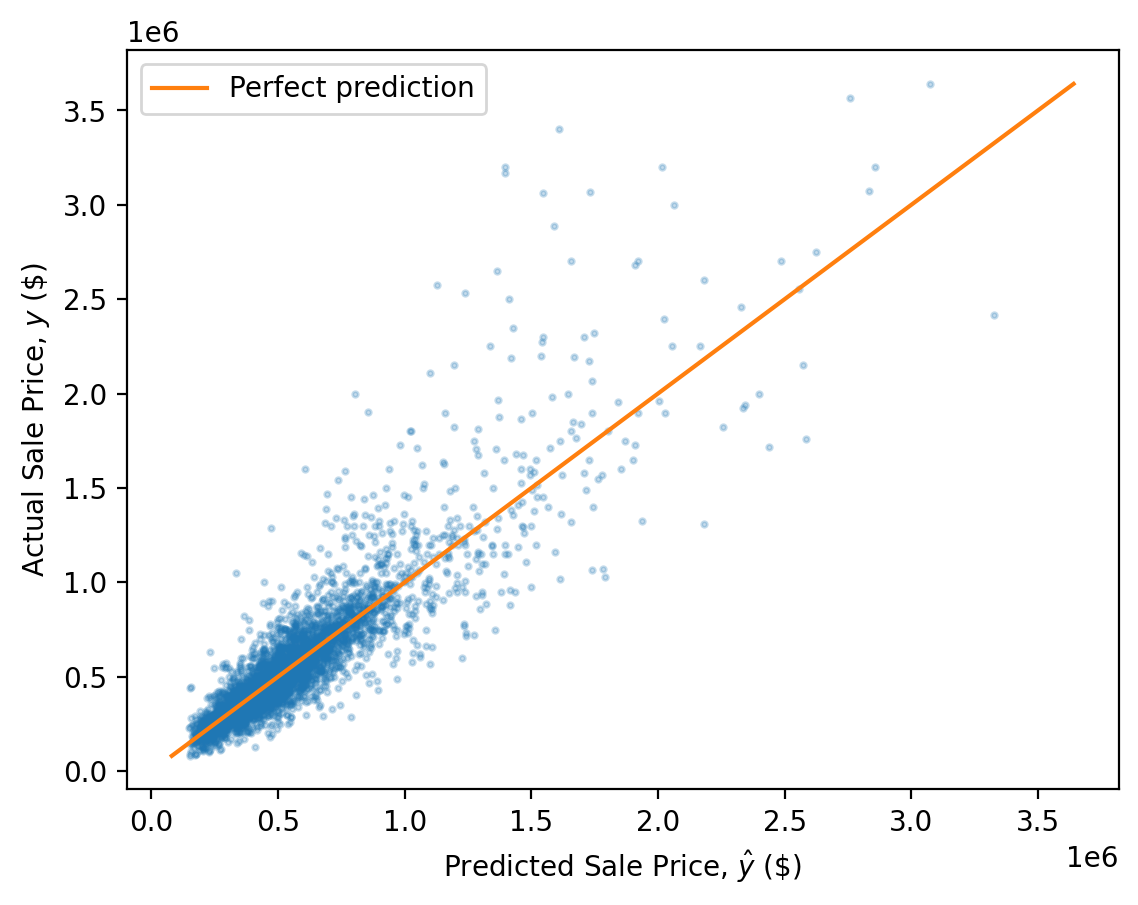

In [97]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(y_prediction,y_test,marker='o',markersize=2,linewidth=0,alpha=0.25)
ax.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],label='Perfect prediction')
ax.set_xlabel(r'Predicted Sale Price, $\hat{y}$ (\$)')
ax.set_ylabel(r'Actual Sale Price, $y$ (\$)')
ax.legend()

The majority of the data are bunched in the lower left corner, unfortunately. To get a better sense of this, let's adjust the scale of x and y axes to be logarithmic, meaning that the major ticks will be factors of 10 (e.g. 10, 100, 1000) rather than equally spaced intervals as would be the case for a linear plot (e.g. 1, 2, 3, 4, ...). In this plot while there is some nuance in interpreting the data in logarithmic space, the base idea that perfect predictions should be along a diagonal line remains true.

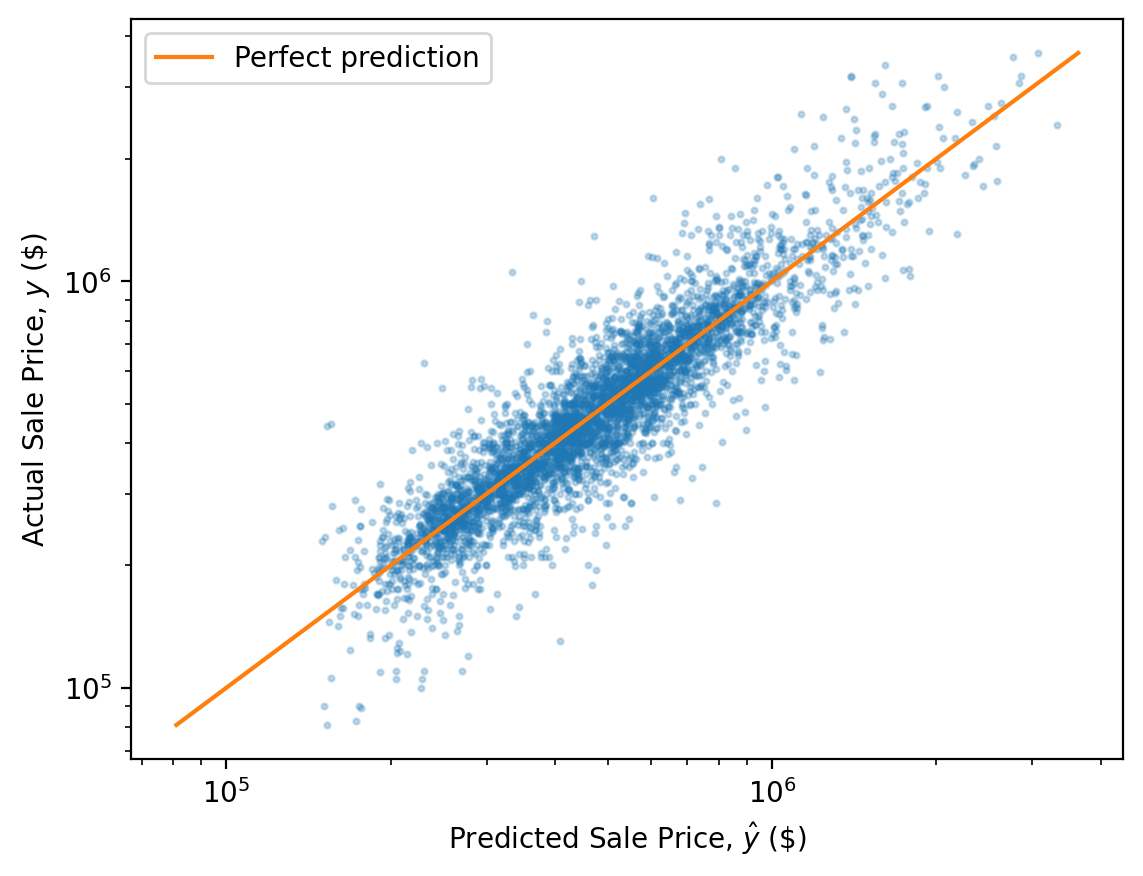

In [98]:
fig, ax = plt.subplots()

ax.loglog(y_prediction,y_test,marker='o',markersize=2,linewidth=0,alpha=0.25)
ax.loglog([min(y_test),max(y_test)],[min(y_test),max(y_test)],label='Perfect prediction')
ax.set_xlabel(r'Predicted Sale Price, $\hat{y}$ (\$)')
ax.set_ylabel(r'Actual Sale Price, $y$ (\$)')
ax.legend()

What's clear is that the predictions do trend together, which is encouraging, but they do not trend together perfectly. We need other ways of evaluating the quality of our predictions. Let's take a look at the distribution of prediction errors by creating a histogram of the prediction errors from our data.

Text(0, 0.5, 'Count')

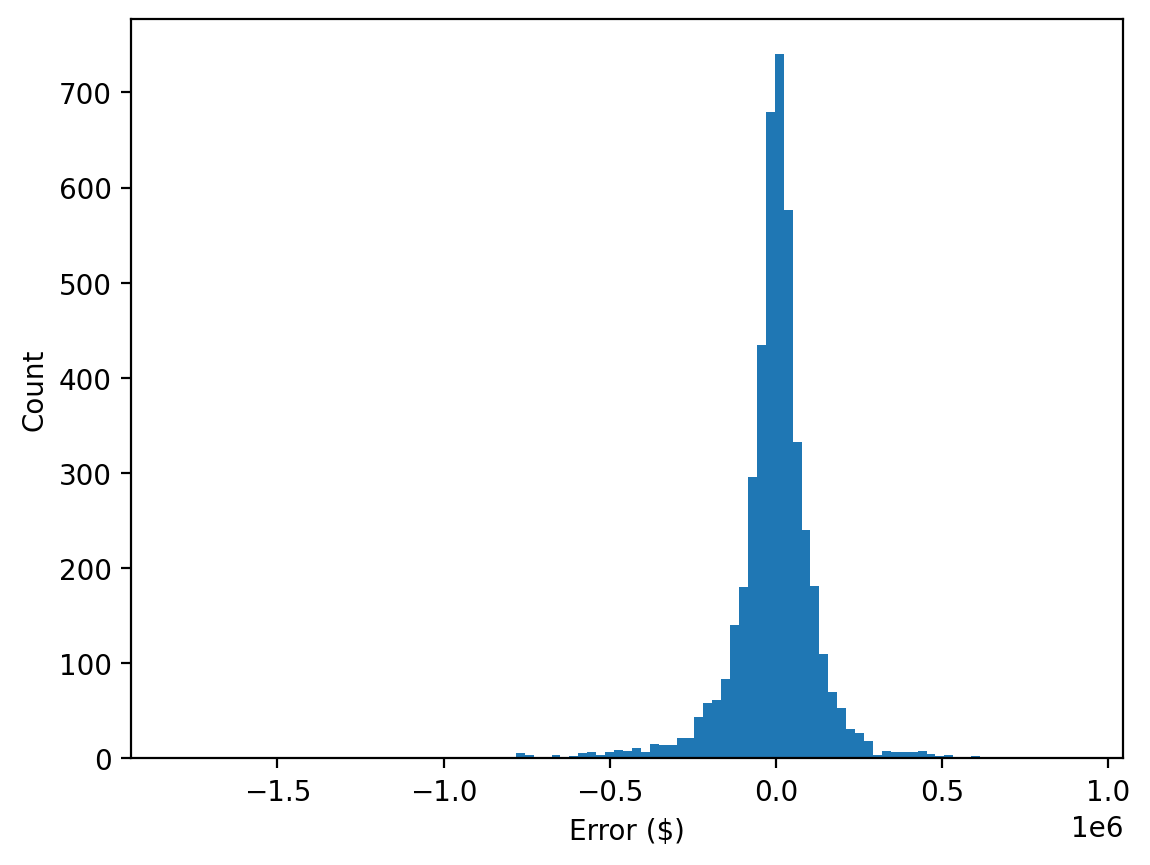

In [99]:
fig, ax = plt.subplots()

nbins = 101
ax.hist(error,bins=101)
ax.set_xlabel('Error ($)')
ax.set_ylabel('Count')

You'll notice that the extent of x is REALLY wide since we must have a few extreme errors. We can fix this by using the `np.clip()` function to set any values higher than a specified value to that value. That's will give us the spikes at either end of the histogram because the data actually extend well-beyond that boundary. However, it's important to view the data closely enough to get a sense for its distribution. If we perform this clip, the results look like this, which is easier to read and interpret:

Text(0, 0.5, 'Count')

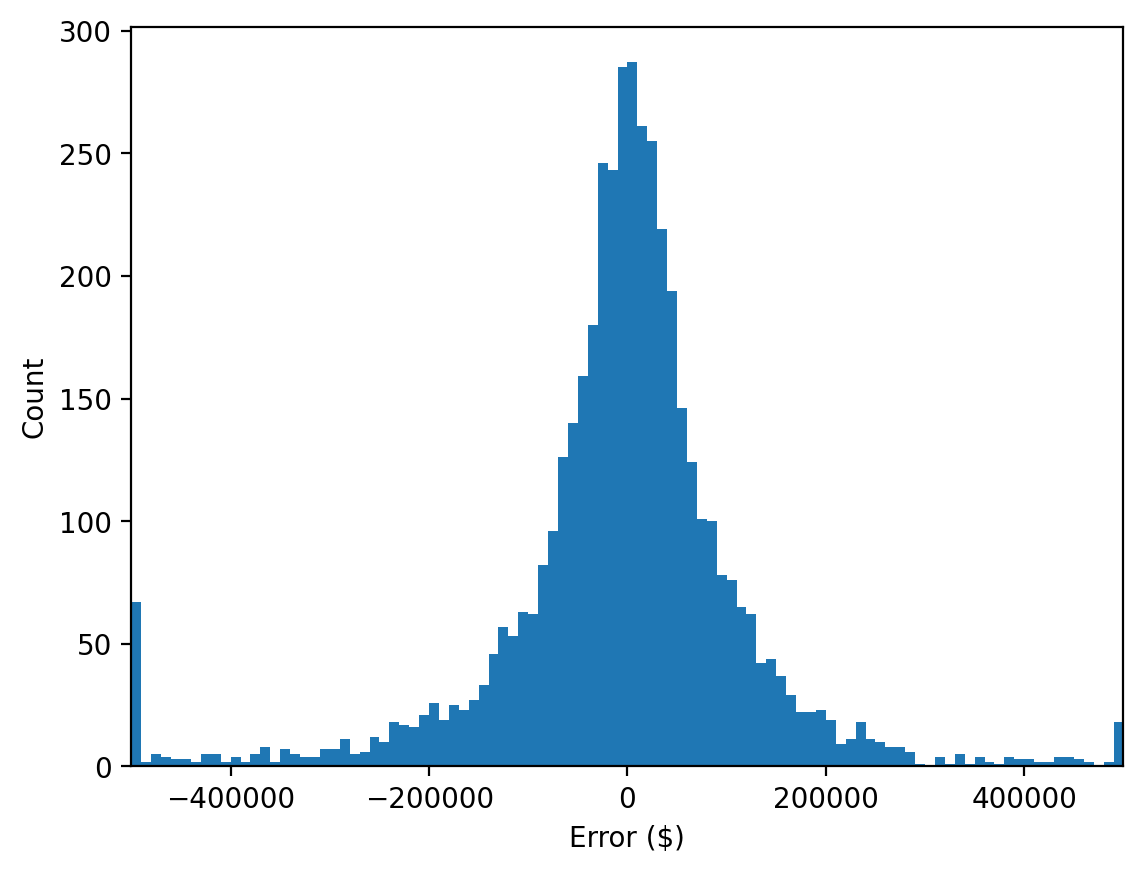

In [100]:
error = y_prediction - y_test

fig, ax = plt.subplots()
minval = -500000
maxval = 500000
nbins = 101
bins = np.linspace(minval,maxval,nbins)

ax.hist(np.clip(error,minval,maxval),bins=bins)
ax.set_xlim([minval,maxval])
ax.set_xlabel('Error ($)')
ax.set_ylabel('Count')

Let's repeat this process, but this time look at *percentage* error:

Text(0, 0.5, 'Count')

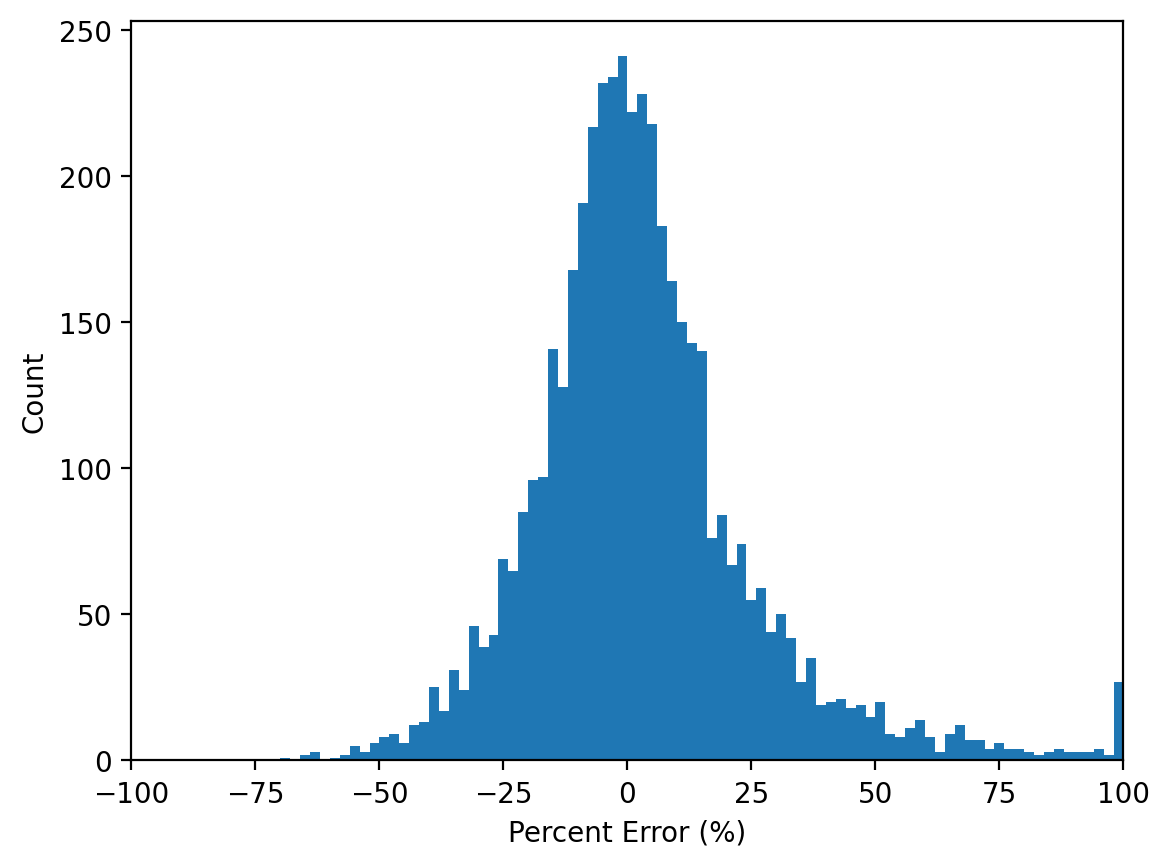

In [101]:
percent_error = (y_prediction - y_test) / y_test * 100

fig, ax = plt.subplots()
minval = -100
maxval = 100
nbins = 101
bins = np.linspace(minval,maxval,nbins)

ax.hist(np.clip(percent_error,minval,maxval),bins=bins)
ax.set_xlim([minval,maxval])
ax.set_xlabel('Percent Error (%)')
ax.set_ylabel('Count')

If we just care about how far from zero these percentages are, we can view absolute percentage error:

Text(0, 0.5, 'Count')

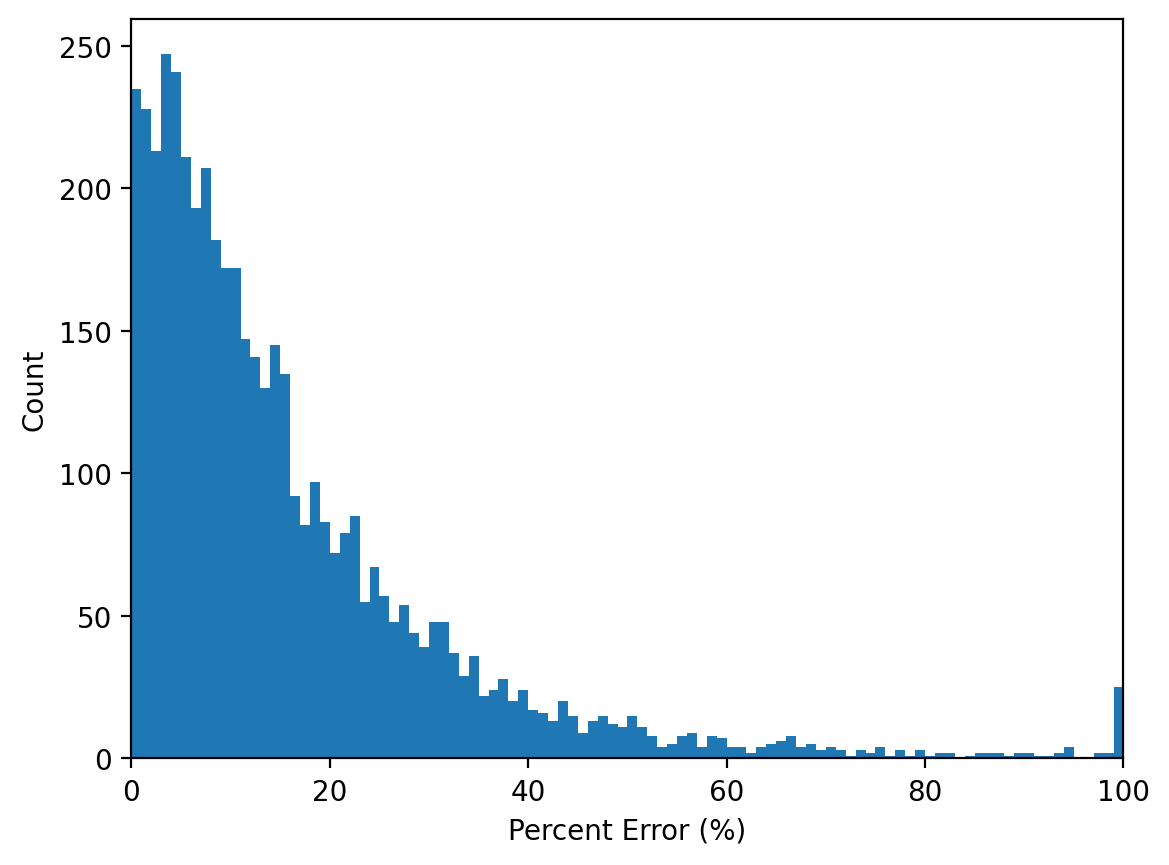

In [102]:
absolute_percent_error = np.abs(percent_error)

fig, ax = plt.subplots()
minval = 0
maxval = 100
nbins = 101
bins = np.linspace(minval,maxval,nbins)

ax.hist(np.clip(absolute_percent_error,minval,maxval),bins=bins)
ax.set_xlim([minval,maxval])
ax.set_xlabel('Percent Error (%)')
ax.set_ylabel('Count')

If we summarizing the above plots into an individual metric, we arrive at our two key metrics: root mean squared error (RMSE) and mean absolute percentage error (MAPE). The RMSE is in the original units of the data (in this case dollars) while the MAPE is a measure relative to the true target value. An error of \$50,000 for a home price of \$100,000 would have an RMSE of \$50,000 and a MAPE of 50% 

$$E_{RMSE} = \sqrt{\frac{1}{N}\displaystyle\sum_{i=1}^N (\hat{y}_i-y_i)^2}$$

$$E_{MAPE}=\frac{1}{N}\displaystyle\sum_{i=1}^N \left| \frac{\hat{y}_i-y_i}{y_i} \right|\times 100\%$$

$$

Here $N$ is the number of observations in our test data and, as usual, $y$ is our target variable and \hat{y} is our prediction. Let's create functions that compute these values for our data to determine measures of the overall error in our data.

In [103]:
def mape(y,yp):
    return np.mean(np.abs((y-yp)/y))*100

In [104]:
def rmse(y,yp):
    return np.sqrt(np.mean((y-yp)**2))

In [117]:
error_rmse = rmse(y_test,y_prediction)
error_mape = mape(y_test,y_prediction)

print(f'RMSE = ${error_rmse}')
print(f'MAPE = {error_mape}%')

RMSE = $160851.1485050382
MAPE = 16.76842304409422%


So we see that on average, we're off by 16.7% of the sale price. And the RMSE is around \$160,000. To contextualize these results it's good to see the full range of sale King's County cost. A great way to explore this is with a histogram of the actual sales prices:

Text(0, 0.5, 'Count')

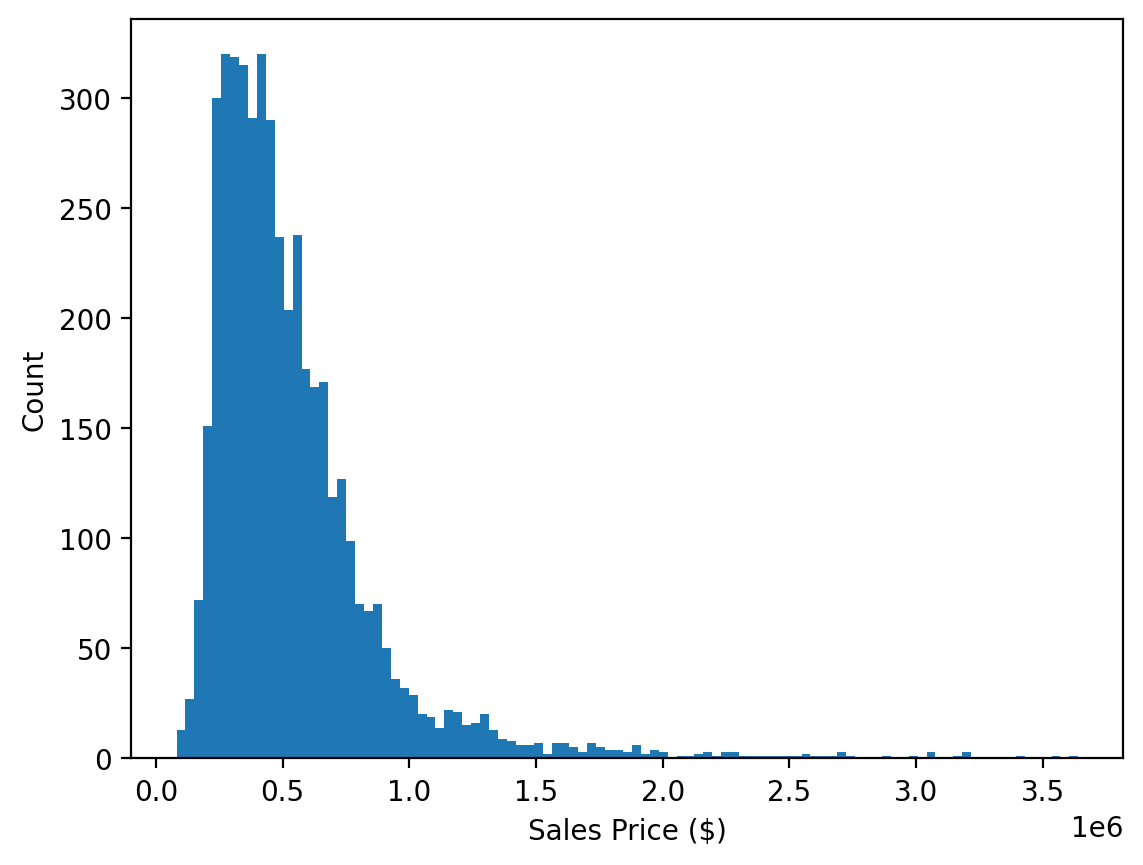

In [106]:
fig, ax = plt.subplots()

ax.hist(y_test,bins=101)
ax.set_xlabel(r'Sales Price (\$)')
ax.set_ylabel('Count')

We can see there is a very long tail to this distribution and the maximum value is over 7 million dollars:

In [107]:
y_test.max()

3640900.0

While this gives us a decent understanding of how well our prediction algorithm performs, one question we could ask is, "can we do better?" One decision we made early on was to set $k$, the number of neighbors used int he calculation, equal to 5. Let's see if you can do better!

Using your `Knn_regression` class, repeat your analysis of the data for different values of $k$ and plot the summary metrics (RMSE and MAPE) for each value of $k$ from 1 to 31 in steps of 2 (so 1, 3, 5, ..., 31). Note: this may take some time to run!

In [108]:
from src.knn import Knn_regression

# Initialize the KNN model
myknn = Knn_regression()

# Train the model
myknn.fit(x_train,y_train)

# Make predictions on the test data
k_vals = np.arange(1,31,2)
results_rmse = []
results_mape = []
for k in k_vals:
    print(f'k = {k}')
    y_prediction = myknn.predict(x_test,k)
    results_rmse.append(rmse(y_test,y_prediction))
    results_mape.append(mape(y_test,y_prediction))

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


Text(0, 0.5, 'MAPE (%)')

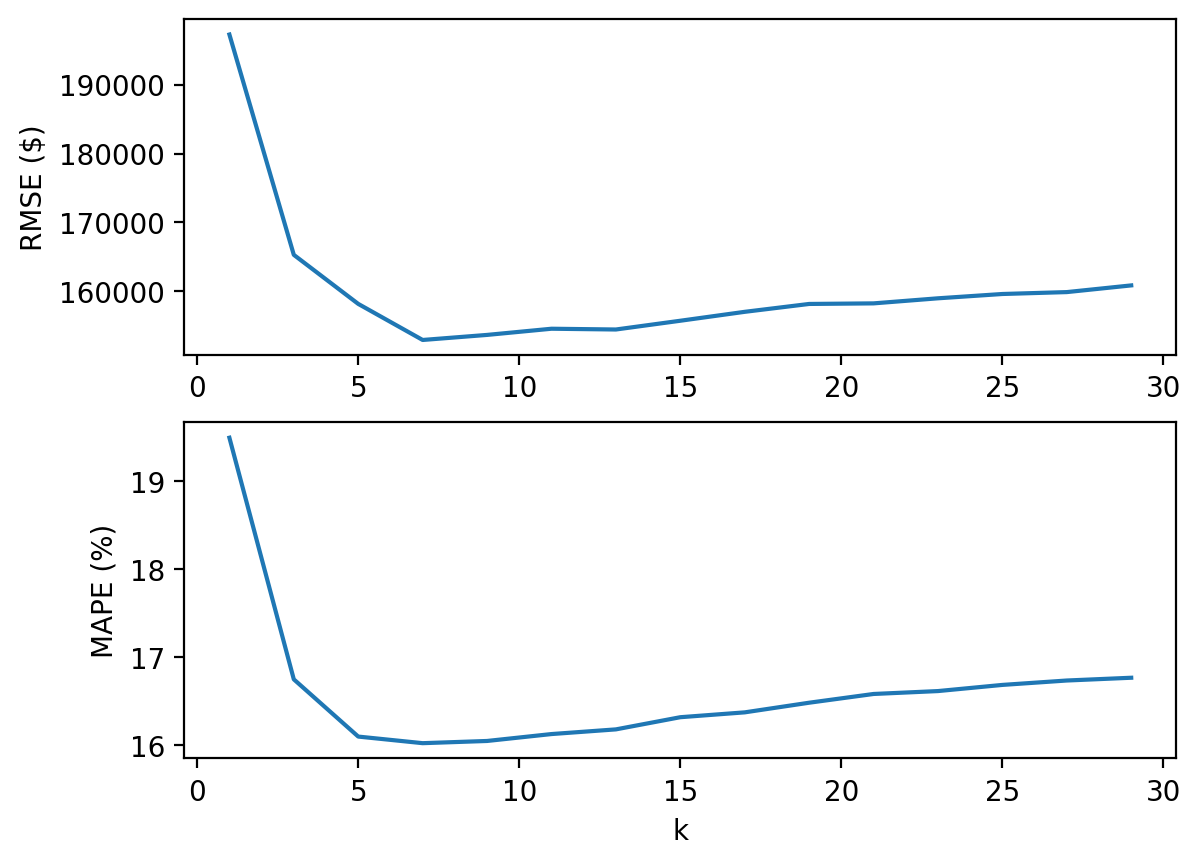

In [109]:
fig, (ax_rmse, ax_mape) = plt.subplots(2,1)

ax_rmse.plot(k_vals,results_rmse)
ax_rmse.set_ylabel(r'RMSE (\$)')
ax_mape.plot(k_vals,results_mape)
ax_mape.set_xlabel('k')
ax_mape.set_ylabel('MAPE (%)')

In [110]:
k_rmse_min = k_vals[np.argmin(results_rmse)]
k_mape_min = k_vals[np.argmin(results_mape)]

In [114]:
min(results_rmse)

152926.51493208567

In [111]:
k_rmse_min

7

In [115]:
min(results_mape)

16.02469650577074

In [112]:
k_mape_min

7

The best $k$ for this problem appears to be 7 and that results in a reduction of both the MAPE to 16.0% and the RMSE to \$153,000 - significant changes from the results with $k=3$ simply by tuning the model!